In [49]:
%matplotlib inline
%load_ext Cython

import networkx as nx
import matplotlib.pyplot as plt
import math
import imp

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
%%cython

import math

ALPHABET = {'A':'T', 'C':'G', 'G':'C', 'T':'A', 'N':'N'}
def revcomp(seq):
    return ''.join(map(lambda x: ALPHABET[x], reversed(seq)))

s = 'GTTGAGGGCCTCTGTCCTGGATGGGGAGATGGTNACTGTGGGNTCCANTCTCCTCTGCNNGATCCCGCGGTACGCCACCTCGTAGTTGTGTCNGCACACTCTNTCCACCGACGCCCGGGCCCCCTCCAGGACTTCCTTCTGGCTGTTCCAGTACTCGGCGCTAGGCCGCCCCTGCGGCGTCACCGCCCGGTACACCCCCACCGCGCTGCCGAAGCGCCCGTGCTCCCCGCGGTGCTGTCTGTGTCTGGGCGCCCCCCGCACGCGCCCCGTACCGGTCGTGAAGGG'
print(revcomp(s))
d = {1:1, 2:2, 3:3}
d
print(dict(filter(lambda x: x[1] > 1, d.items())))
math.ceil(1.1)
5 / 3
a = []
a.extend([])
a.extend([])
a.extend([1])
a.extend([])
a

CCCTTCACGACCGGTACGGGGCGCGTGCGGGGGGCGCCCAGACACAGACAGCACCGCGGGGAGCACGGGCGCTTCGGCAGCGCGGTGGGGGTGTACCGGGCGGTGACGCCGCAGGGGCGGCCTAGCGCCGAGTACTGGAACAGCCAGAAGGAAGTCCTGGAGGGGGCCCGGGCGTCGGTGGANAGAGTGTGCNGACACAACTACGAGGTGGCGTACCGCGGGATCNNGCAGAGGAGANTGGANCCCACAGTNACCATCTCCCCATCCAGGACAGAGGCCCTCAAC
{2: 2, 3: 3}


In [ ]:
import clusterisation
imp.reload(clusterisation)

F1 = "data/uv.__class1_amp1__.R1.fastq"
#F1 = "data/uv.__class1_amp1__.R2.fastq"
#F1 = "data/ash110.__class1_amp1__.R1.fastq"
#F1 = "data/70.__class2_amp2__.R1.fastq"
#F1 = "data/70.__class1_amp1__.R1.fastq"

seq = clusterisation.clusterise_sequences(F1, 
                                          replace_threshold = 14, 
                                          low_threshold = 60, 
                                          high_threshold = 90, 
                                          n_clust_hamm = 40, 
                                          h_clust_hamm = 30, 
                                          max_sequences = 500)

In [121]:
def get_sequences(filepath):
    sequences = []
    with open(filepath) as file:
        sequences = [(x.split()[1], float(x.split()[0])) for x in file]
    print([x[1] for x in sequences][:20])
    return sequences

filename = "tmp.topseq1"

minor_f = filename + ".minor.txt"
major_f = filename + ".major.txt"

minors = get_sequences(minor_f)
majors = get_sequences(major_f)
# print(majors)
# print(len(sequences))
# print([x[1] for x in sequences])
# print([x[0].count('N') for x in sequences])

[]
[4605.163, 2932.819, 1783.006, 797.341, 739.612, 719.628, 335.686, 263.876, 257.843, 200.896, 180.264, 107.939, 92.935, 75.363, 72.05, 69.048, 66.038, 62.031, 56.964, 48.045]


# nodes 500
# edges 2609
# triangles 145


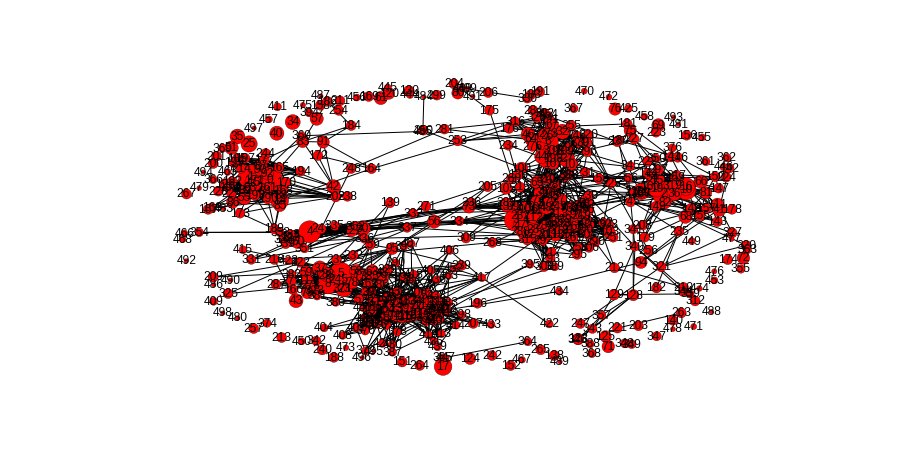

In [122]:
MAX_ERR = 10

def hamming_check(alpha, beta, max_err):
	if len(alpha) != len(beta): 
		print("!!!!")
	err = 0
	for a, b in zip(alpha, beta):
		err += (a != b) and (a != 'N') and (b != 'N')
		if err > max_err:
			return False
	return True


def make_graph_old(sequences, max_err):
    G=nx.Graph()
    for i in range(len(sequences)):
        G.add_node(i)
    for i in range(len(sequences) - 1):
        for j in range(i, len(sequences)):
            if hamming_check(sequences[i][0], sequences[j][0], max_err):
                G.add_edge(i, j)
    return G


def single_graph(sequences, max_err):
    node_sizes = [math.log2(x[1]) for x in sequences]
    node_sizes_min = min(node_sizes)
    node_sizes_max = max(node_sizes)
    for i in range(len(node_sizes)):
        node_sizes[i] = 20 + 600 * (node_sizes[i] - node_sizes_min) / (node_sizes_max - node_sizes_min)

    G = make_graph_old(sequences, max_err)
    print("# nodes", G.number_of_nodes())
    print("# edges", G.number_of_edges())
    print("# triangles", nx.triangles(G, 0))
    
#     for x in nx.enumerate_all_cliques(G):
#         if len(x) == 3 or len(x) == 4:
#             print(x)
    
    pos = nx.spring_layout(G, k = .25)
    nx.draw(G, pos, node_size = node_sizes)
    nx.draw_networkx_labels(G, pos)
    plt.show()


def make_graph(minors, majors, max_err):
    neis = {x: [] for x in map(lambda x: x[0], majors)}
    
    G=nx.Graph()
    for i in range(len(minors) + len(majors)):
        G.add_node(i)
    for i in range(len(minors)):
        for j in range(len(majors)):
            if hamming_check(minors[i][0], majors[j][0], max_err):
                G.add_edge(i, len(minors) + j)
                neis[majors[j][0]].append(i)
    return G, neis


def bigraph(minors, majors, max_err):
    node_sizes = [math.log2(x[1]) for x in minors + majors]
    node_sizes_min = min(node_sizes)
    node_sizes_max = max(node_sizes)
    for i in range(len(node_sizes)):
        node_sizes[i] = 20 + 600 * (node_sizes[i] - node_sizes_min) / (node_sizes_max - node_sizes_min)

    G, neis = make_graph(minors, majors, max_err)
    print("# nodes", G.number_of_nodes())
    print("# edges", G.number_of_edges())
    print("# triangles", nx.triangles(G, 0))
    pos = nx.spring_layout(G, k = .25)
    # nx.draw(G, pos, node_size = node_sizes)
    nx.draw_networkx_nodes(G, 
                           pos, 
                           nodelist=range(len(minors)), 
                           node_color="r", 
                           node_size=node_sizes[:len(minors)])
    nx.draw_networkx_nodes(G, 
                           pos, 
                           nodelist=range(len(minors), len(majors) + len(minors)), 
                           node_color="b", 
                           node_size = node_sizes[len(minors) : len(majors) + len(minors)])
    nx.draw_networkx_edges(G, pos)
    nx.draw_networkx_labels(G, pos)
    plt.show()


# bigraph(minors, majors, 10)
#single_graph(minors, 10)
single_graph(majors, 2)

In [ ]:
sequences = majors
G = make_graph_old(sequences, 20)
pr = nx.pagerank_numpy(G, alpha = .05, personalization = {i: sequences[i][1] for i in range(len(sequences))})
for i, x in enumerate(nx.connected_components(G)):
    print(i+1, ": ", sorted(list(zip(x, [round(pr[y], 4) for y in x], [sequences[y][1] for y in x])), key = lambda x: x[1], reverse = True), sep = '')
pos = nx.spring_layout(G, k = .2)
nx.draw(G, pos, node_size = [2000 * x[1] for x in pr.items()])
nx.draw_networkx_labels(G, pos)
plt.show()

In [101]:
# G = make_graph_old(majors, 20)
# comms = nx.community.k_clique_communities(G)
import numpy as np
a,b,c = np.trunc(np.percentile([1,1,1,2,3,45,3,5,3,1,1,1], [10, 50, 90]))
print(np.percentile([1,1,1,2,3,45,3,5,3,1,1,1], [10, 50, 90]))
print(a,b,c)

[ 1.   1.5  4.8]
1.0 1.0 4.0
